# LSTM and data checks

In [1]:
import math
import csv
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler


# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## dataset without balancing 

In [2]:
from torch.utils.data import Dataset, DataLoader
class PDControlDataset(Dataset):
    """Neurogenertive features dataset."""

    def __init__(self, csv_file, root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
           
        """
        self.df = pd.read_csv(csv_file) # 
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path = os.path.join(self.root_dir,
                                self.df.iloc[idx, 1])
        label = self.convert_label(self.df.iloc[idx, 2])
        features  = pd.read_csv(file_path,  header=None).values
        sample = {'data': features, 'label': label}


        return sample
    
    def convert_label(self, label):
        if label == 'control':
            return 0
        elif label == 'PDL':
            return 1
        elif label == 'PDR':
            return 1
        else:
            raise Exception('ONLY control, PDL, PDR are currently supported')

In [3]:
folder_p = 'C:/Users/KHOKHLOVAM/Documents/projects/kotelnikov/data/lstm_trials/n200_4_features/'              
dataset = PDControlDataset(folder_p +'/all_data_200N.csv', root_dir=folder_p)

In [8]:
data_train = DataLoader(dataset, batch_size=8,shuffle=True) # TODO to fix the dataloader ... 

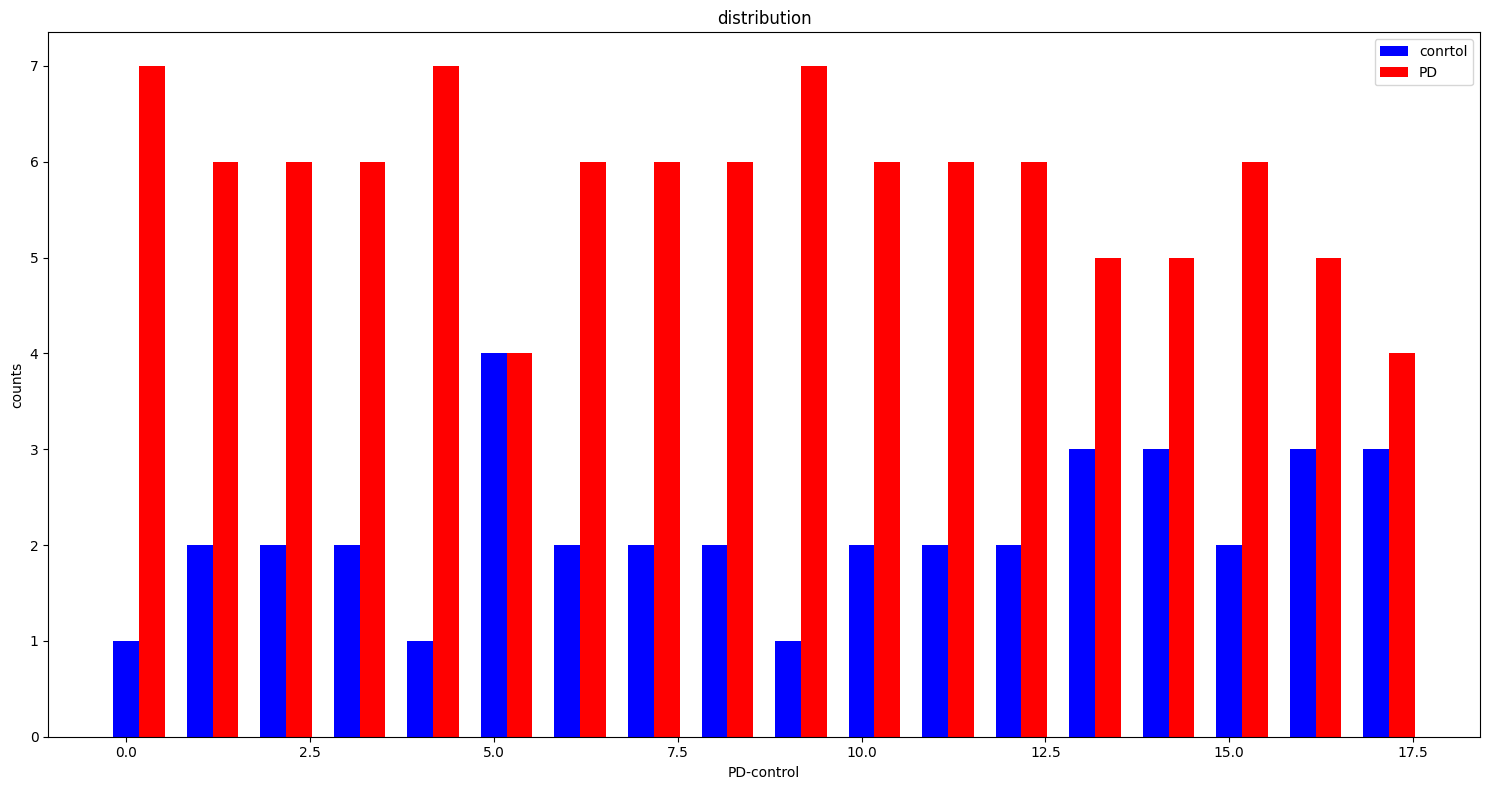

In [9]:
zeros = []
ones = []
for  data in data_train:  
    lbl = data['label']
    #X  = torch.transpose(data['data'],2,1).to(device)
    res, cnts = np.unique(lbl, return_counts=True)
    if len(res) == 2:
        zeros.append(cnts[0])
        ones.append(cnts[1])
    else:
        if res == 0:
            zeros.append(cnts[0])
            ones.append(0)
        else:
            zeros.append(0)
            ones.append(cnts[0])

num_samples = len(zeros)
plt.figure(figsize=(15, 8))
plt.bar(np.arange(len(ones[:num_samples])), zeros[:num_samples], color='b', label='conrtol', width=0.35)
plt.bar(np.arange(len(ones[:num_samples]))+0.35, ones[:num_samples], color='r', label='PD', width=0.35)
plt.xlabel('PD-control')
plt.ylabel('counts')
plt.title('distribution')
plt.legend()
plt.tight_layout()
plt.show()

## dataset with balancing 

In [15]:
# let's try to train the first model again! We augment the train_data, but not the test_data
batch_size = 8
Control_weight  = 39/(39+104)
PD_weight = 104/(39+104) #[sum( [39,104])/c for c in [39,104]] 
target = torch.cat((torch.ones(39)*2, torch.ones(104))).long()
sample_weights = target
sampler = WeightedRandomSampler(sample_weights,len(target), replacement = True)
train_iter = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True) 
print(sample_weights)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


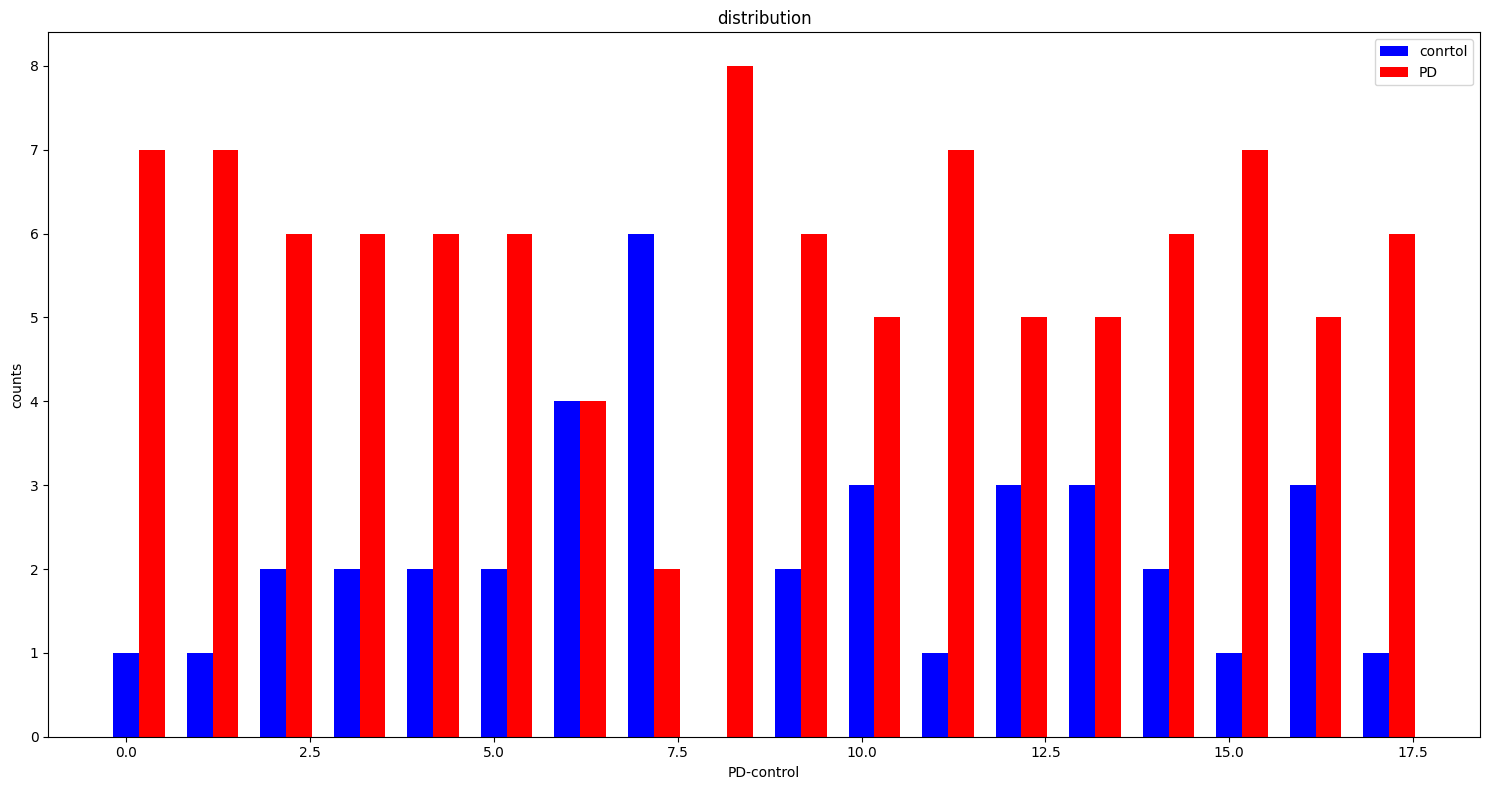

In [16]:
zeros = []
ones = []
for  data in train_iter:  
    lbl = data['label']
    #X  = torch.transpose(data['data'],2,1).to(device)
    res, cnts = np.unique(lbl, return_counts=True)
    if len(res) == 2:
        zeros.append(cnts[0])
        ones.append(cnts[1])
    else:
        if res == 0:
            zeros.append(cnts[0])
            ones.append(0)
        else:
            zeros.append(0)
            ones.append(cnts[0])

num_samples = len(zeros)
plt.figure(figsize=(15, 8))
plt.bar(np.arange(len(ones[:num_samples])), zeros[:num_samples], color='b', label='conrtol', width=0.35)
plt.bar(np.arange(len(ones[:num_samples]))+0.35, ones[:num_samples], color='r', label='PD', width=0.35)
plt.xlabel('PD-control')
plt.ylabel('counts')
plt.title('distribution')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class LSTM(nn.Module):

    def __init__(self, dimension=128, input_size = 4):
        super(LSTM, self).__init__()

        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, X, N=200):
        ''' N is the legnth of a feature vector'''
        lstm_output, _ = self.lstm(X)

        out_forward = lstm_output[range(len(lstm_output)), N - 1, :self.dimension]
        out_reverse = lstm_output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        X_fea = self.drop(out_reduced)

        X_fea = self.fc(X_fea)
        X_fea = torch.squeeze(X_fea, 1)
        out = torch.sigmoid(X_fea)

        return out